# MCMC for the mass distribution of EMRIs

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner
import matplotlib as mpl
import seaborn as sns


%matplotlib inline
np.random.seed(1234)


params = {'axes.labelsize': 18,
          'font.family': 'serif',
          'font.serif': 'Computer Modern Raman',
          'font.size': 18,
          'axes.linewidth': 1,
          'legend.fontsize': 15,
          'xtick.labelsize': 18,
          'xtick.top': True,
          'ytick.labelsize': 18,
          'ytick.right': True,
          'axes.grid' : True,
          'text.usetex': True,
          'savefig.dpi' : 100,
          'lines.markersize' : 14,
          'axes.formatter.limits' : (-3,3)}

mpl.rcParams.update(params)

We fit a BH mass functionsource parameter given by the mass, $\theta=M$. This example follows the EMRI mass function [e-Print: 1004.1921 ("GTV")]:

$$\frac{dN}{d\ln M}=A_0\big(\frac{M}{M_*}\big)^{\alpha_0} \quad\Rightarrow\quad p(M|\lambda)=\mathcal{N} M^{\alpha_0-1}.$$

We are interested in the $ \lambda=\alpha_0$ population parameter. We are assuming that the amplitude $A_0$ does not carry information about the system, but only about the rate of events.

In [2]:
"""
Parameters
"""

N_obs = 1000
N_samp_per_obs = 10

# Inputs to get the true ln M distribution.
# Notice that M runs from 10^4 to 10^7 in GTV.

alpha0_t = 0.00001 # Choose flat spectral profile.
M_min=10000. ;   logM_min = np.log(M_min)
M_max=10000000.; logM_max = np.log(M_max)

In [3]:
def model(lnM,alpha):
    
    """
    Model for p(d|lambda).
    
    Input:
    
    - data    (The noisy generated data where we expect the masses to be.)
    - alpha   (Spectral index of the mass distribution.)
    
    """
    
    M = np.exp(lnM) # mass observations
    norm  = alpha/(M_max**alpha-M_min**alpha)
    
    
    return norm*M**(alpha-1)

The hyperlikelihood is (with $\theta = \ln M$ and $\lambda=\alpha$):

$$
p(d|\lambda) = \prod_{i=1}^{N_\text{obs}} p(d_i|\lambda) = \prod_{i=1}^{N_\text{obs}} \int p(d_i|\theta_i)p_\text{pop}(\theta_i|\lambda) d\theta_i,
$$

which can be rearranged through Bayes theorem to give

$$
    p(d|\lambda) = \prod_{i=1}^{N_\text{obs}} \int \frac{p(\theta_i|d_i) p(\theta_i)}{p(d_i)}p_\text{pop}(\theta_i|\lambda) d\theta_i.
$$

The integral can be solved with Monte Carlo methods drawing $N_\text{samp}$ samples from the posterior, $\theta_{ij}\sim p(\theta_{i}|d_i)$ ($j$ indexing the samples),

$$
   p(d|\lambda) = \prod_{i=1}^{N_\text{obs}} \frac{1}{N_\text{samp}}\sum_{j=1}^{N_\text{samp}} \frac{p(\theta_{ij})}{p(d_i)}p_\text{pop}(\theta_{ij}|\lambda)\quad \Rightarrow \quad \log p(d|\lambda)\propto \sum_{i=1}^{N_\text{obs}}\sum_{j=1}^{N_\text{samp}} p_\text{pop}(\theta_{ij}|\lambda)\equiv \sum_{i=1}^{N_\text{obs}}\sum_{j=1}^{N_\text{samp}} p_{\text{pop},ij}.
$$

In the last line, we ignore normalization factors and take the log of the hyperlikelihood. The final expression is coded up below.

In [4]:
# Limits of (flat) hyperpriors.

hyperprior_min = -10.0
hyperprior_max = 10.0

def log_likelihood_numerical(params, data):
    
     
    support = ( # Here is the support limits for hyperpriors.
                (params[0] >= hyperprior_min)&
                (params[0] <= hyperprior_max)
                )
    
    log_likelihood=0
    
    for i in np.arange(N_obs):
        
        ppop_ij = model(data[i,:],params[0])  # N_samp-long array for population model.
        sum_ppop = np.sum(ppop_ij)            # internal sum of population model over N_samp.
        log_likelihood += np.log(sum_ppop)    # add the samples drawn over N_obs in the loop.
        
    out = np.where(support,log_likelihood,-np.inf)  # Only retain likelihood if supported.
    
    
    # Force nans away.
    if np.isfinite(out):
        return out
    else:
        return -np.inf


Starting from the probability density $p(M|\lambda)=\mathcal{N} M^{\alpha_0-1}$, we can use the method of inversion to get the source parameter M. In particular, we define the cumulative density function,

$u:=\text{CDF}(M)= \mathcal{N}\int_{M_\text{min}}^{M}M^{\alpha_0-1}dM = \alpha_0^{-1}\mathcal{N}M^{\alpha_0}\big|_{M_\text{min}}^{M}=\alpha_0^{-1}\mathcal{N}(M^{\alpha_0}-M^{\alpha_0}_{\text{min}})$.

The normalization factor can be calculated imposing that $\lim_{M\rightarrow M_{\text{min}}} u=1$, which gives immediately:

$\mathcal{N}=\frac{\alpha_0}{M^{\alpha_0}_\text{max}-M^{\alpha_0}_{\text{min}}}$.

Now, we get M in terms of $u$, 

$\quad M^{\alpha_0}=\alpha_0\mathcal{N}^{-1} u +M^{\alpha_0}_{\text{min}}\quad\Longrightarrow \quad \ln M =\frac{1}{\alpha_0} \ln\big[(M^{\alpha_0}_\text{max}-M^{\alpha_0}_{\text{min}})\, u +M^{\alpha_0}_{\text{min}}\big]\quad $ (true parameter distribution).

In [5]:
sigma = 0.1
noise = np.random.normal(0,sigma,size = N_obs)

"""
Data draws.
"""

u = np.random.uniform(size=N_obs)
logM_t=alpha0_t**-1 * np.log((M_max**(alpha0_t)-M_min**(alpha0_t))*u+ M_min**(alpha0_t)*np.ones(N_obs))

d_i = noise + logM_t  # observation model made of noise + true population.


"""
Data array. The structure of data is such that Data[i,j] is the jth posterior sample from event i.
We assume the observation model p(d|theta) is a normal gaussian.

"""

data=np.zeros((N_obs,N_samp_per_obs))
for i in np.arange(N_obs):
    
    data[i,:]=np.random.normal(d_i[i],sigma,size=N_samp_per_obs)

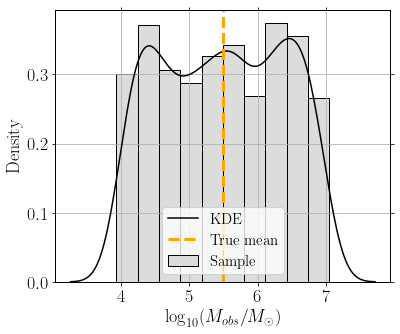

In [6]:
fig, ax = plt.subplots(1,1,figsize=(6,5))
plt.hist(np.log10(np.exp(d_i)),density=True,label='Sample',bins=10,histtype = 'bar',
                               color ='gainsboro', edgecolor='black')
sns.kdeplot(np.array(np.log10(np.exp(d_i))), label='KDE',c='k')
plt.axvline(x=np.log10(np.exp(np.mean(logM_t))), label='True mean', c='orange',ls='--',lw=3)

plt.xlabel('$\log_{10}(M_{obs}/M_\odot)$')
plt.ylabel('Density')
plt.legend(loc='best')

In [7]:
"""
Choose which data and likelihood.
"""

which_likelihood = log_likelihood_numerical
which_data = data

In [8]:
n_iter = 10000
ndim = 1; nwalkers = 2

pos_init0 = [alpha0_t]
p0 = pos_init0*(1+0.001* np.random.randn(nwalkers, ndim))

sampler = emcee.EnsembleSampler(nwalkers, ndim, which_likelihood, args=[which_data])

run = sampler.run_mcmc(p0, n_iter, progress=True)

100%|█████████████████████████████████████| 10000/10000 [03:28<00:00, 48.06it/s]


In [9]:
"""
Collect the samples here.
"""
burnin = 1500

chains = sampler.get_chain(discard=burnin, thin=1, flat=False)
alpha_samples = chains[:,:,0].flatten()

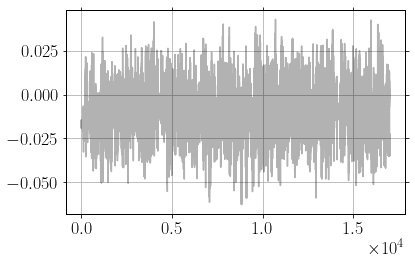

In [10]:
plt.plot(alpha_samples, "k", alpha=0.3)
plt.tight_layout()
plt.show()

In [11]:
def gaussian(d,mu,Sigma_sq):
    
    num = np.exp(-0.5*(d-mu)**2/Sigma_sq)
    den = np.sqrt(2*np.pi*Sigma_sq)
    return num/den

In both the case with and without selection effects the Fisher estimate is dominated by the first term in the integral, which from the paper reads

$$
(\Gamma_\lambda)_{ij} \approx -\int \frac{\partial^2 \ln (p(\theta | \lambda)/p_{\rm det}(\lambda))}{\partial\lambda^i \partial\lambda^j} \, \frac{p_{\rm det}(\theta)}{p_{\rm det}(\lambda)} p(\theta |\lambda) {\rm d} \theta.
$$

In the simplifying case in which there are no selection effects, the estimate is analytically found to be (see $\texttt{Mathematica}$ notebook)

$$
\Gamma_\alpha \approx N_\text{obs}\left(\frac{1}{\alpha^2}-\frac{M_\text{max}^\alpha M_\text{min}^\alpha (\ln M_\text{max}-\ln M_\text{min})^2}{(M_\text{max}^\alpha-M_\text{min}^\alpha)^2}\right)
$$

In [12]:
# Estimates without selection effects.


#This expression is only valid for 1D fitting, and crucially it only accounts for the first 
#term in the FM. More accurate estimates can be obtained with the accompanying Mathematica 
#notebook. However we check that other terms are subdominant compared to the one used here.

from sympy.parsing import mathematica as M
Dalpha_simpified = M.mathematica('Sqrt[1/(Nobs*(alpha^(-2) - (Mmax^alpha*Mmin^alpha*(Log[Mmax] - Log[Mmin])^2)/(Mmax^alpha - Mmin^alpha)^2))]')

def Dalpha(Nobs,alpha,Mmin,Mmax):
    
    out = Dalpha_simpified.subs([('Nobs',Nobs),('alpha',alpha),('Mmax',Mmax),('Mmin',Mmin)]).evalf()
    
    return float(out)

print('Analytical expression for the variance on the spectral index:')
Dalpha_simpified


Analytical expression for the variance on the spectral index:


sqrt(1/(Nobs*(-Mmax**alpha*Mmin**alpha*(log(Mmax) - log(Mmin))**2/(Mmax**alpha - Mmin**alpha)**2 + alpha**(-2))))

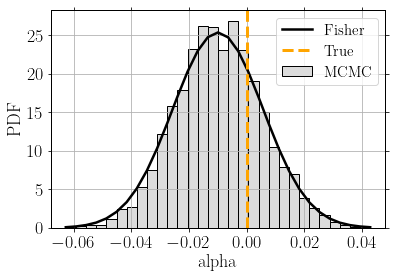

In [13]:
"""
Posteriors with Fisher estimates
"""


_, bins_alpha, _= plt.hist(alpha_samples, 30, histtype = 'bar',
                               color ='gainsboro', density=True, edgecolor='black', label='MCMC')


Da = Dalpha(N_obs,alpha0_t,M_min,M_max) # From Mathematica notebook.
bins_alpha= np.array(bins_alpha)
plt.plot(bins_alpha, gaussian(bins_alpha,alpha0_t-0.01,Da**2), color='black', 
         lw=2.5,label='Fisher')


plt.axvline(x=alpha0_t, label='True', c='orange',ls='--',lw=3)
plt.xlabel('alpha')
plt.ylabel('PDF')
plt.legend()
plt.show()

